# Training and evaluation with the built-in methods

## 설정

In [3]:
# tensorflow.org/guide/keras/train_and_evaluate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 시작하기

이 안내서는 훈련 및 유효성 검증을 위해 내장 API를 사용할 때의 훈련, 평가 및 예측 (추론) 모델 (예 : `model.fit()` , `model.evaluate()` , `model.predict()` )에 대해 설명합니다.

고유한 훈련 단계 함수를 지정하면서 `fit()`을 사용하려면 <a href="https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/" data-md-type="link">" `fit()`에서 이루어지는 작업 사용자 정의하기"</a> 가이드를 참조하세요.

고유한 훈련 및 평가 루프를 처음부터 작성하려면 ["처음부터 훈련 루프 작성"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/) 안내서를 참조하십시오.

일반적으로, 내장 루프를 사용하든 직접 작성하든 관계없이 모델 훈련 및 유효성 검사는 모든 종류의 Keras 모델(순차 모델, Functional API로 작성된 모델 및 모델 하위 클래스화를 통해 처음부터 작성된 모델)에서 완전히 동일하게 작동합니다.

이 가이드는 분산 교육에 대해서는 다루지 않습니다. 분산 교육에 대해서는 [멀티 GPU 및 분산 교육 안내서를](https://keras.io/guides/distributed_training/) 참조하십시오.

## API 개요 : 첫 번째 엔드 투 엔드 예제

데이터를 모델의 내장 훈련 루프로 전달할 때는 **NumPy 배열**(데이터가 작고 메모리에 맞는 경우) 또는 **`tf.data Dataset` 객체**를 사용해야 합니다. 다음 몇 단락에서는 옵티마이저, 손실 및 메트릭을 사용하는 방법을 보여주기 위해 MNIST 데이터세트를 NumPy 배열로 사용하겠습니다.

다음 모델을 고려해 보겠습니다 (여기서는 Functional API를 사용하여 빌드하지만 Sequential 모델 또는 하위 클래스 모델 일 수도 있음).

In [ ]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

일반적인 엔드 투 엔드 워크 플로는 다음과 같이 구성되어 있습니다.

- 학습
- 원래 교육 데이터에서 생성 된 홀드 아웃 세트에 대한 유효성 검사
- 테스트 데이터에 대한 평가

이 예에서는 MNIST 데이터를 사용합니다.

In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape) # (60000, 28, 28)

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
print(x_train.shape) # (60000, 784)
 # (50000, 784)
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]
print(x_train.shape) # (50000, 784)
print(x_val.shape)   # (10000, 784)

(60000, 28, 28)
(60000, 784)
(50000, 784)
(10000, 784)


훈련 구성(최적화 프로그램, 손실, 메트릭)을 지정합니다.

In [ ]:
# np.equal([1,2], [1,0]) # array([ True, False])
np.equal([[1],[2]], [1,0]) # 열 브로드캐스팅 (S403 참조) array([[ True, False],
                                                                      # [False, False]])

In [ ]:
import numpy as np

sample_weight=np.array([0.7, 0.3])   # (2, )
y_true = np.array([[2], 
                   [1]])             # (2, 1)
y_pred = np.array([[0.1, 0.6, 0.3], 
                   [0.05, 0.95, 0]]) # (2, 3)

print(np.argmax(y_pred, axis=1))     # y_pred의 제일 큰 인덱스값 출력 [1, 1] (2, )
print(np.equal(y_true, np.argmax(y_pred, axis=1))) # 열 브로드캐스팅 (S404 참조) [[False], [True]](2,1)

acc = np.dot(sample_weight, np.equal(y_true, np.argmax(y_pred, axis=1))) # (s405 참조)
print(acc) # [0.3 0.3]

In [ ]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state([[2], [1]], [[0.1, 0.6, 0.3], [0.05, 0.95, 0]]) # [[2], [1]]: 정답 (샘플 2개를 동시에 연산) 
# [[0.1, 0.6, 0.3], [0.05, 0.95, 0]]: 예측 [0.1, 0.6, 0.3] => index 1 (False), [0.05, 0.95, 0] => index 1 (True)
print(m.result().numpy()) # 0.5 

m.reset_state()
m.update_state([[2], [1]], [[0.1, 0.6, 0.3], [0.05, 0.95, 0]], sample_weight=[0.7, 0.3]) # 샘플 가중치 부여
# acc = np.dot(sample_weight, np.equal(y_true, np.argmax(y_pred, axis=1))
print(m.result().numpy()) # 0.3

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(), # Index로 다중분류
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()], # Train, Val의 맞은 것의 개수 기록
)

`fit()`를 호출하여 데이터를 "batch_size" 크기의 "배치"로 분할하고 지정된 수의 "epoch"에 대해 전체 데이터세트를 반복 처리하여 모델을 훈련시킵니다.

In [ ]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

반환되는 "이력" 객체는 훈련 중 손실 값과 메트릭 값에 대한 레코드를 유지합니다.

In [ ]:
history.history

`evaluate()`를 통해 테스트 데이터에 대해 모델을 평가합니다.

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

이제이 워크 플로의 각 부분을 자세히 검토하겠습니다.

## `compile()` 메소드 : 손실, 메트릭 및 최적화 프로그램 지정

`fit()` 으로 모델을 학습하려면 손실 함수, 최적화 프로그램 및 선택적으로 모니터링 할 일부 메트릭을 지정해야합니다.

이것을 `compile()` 메소드의 인수로 모델에 전달합니다.

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 인수는 목록이어야합니다. 모델에는 여러 개의 메트릭이있을 수 있습니다.

모델에 여러 개의 출력이있는 경우 각 출력에 대해 서로 다른 손실 및 메트릭을 지정하고 모델의 총 손실에 대한 각 출력의 기여도를 조정할 수 있습니다. 이에 대한 자세한 내용은 **"다중 입력, 다중 출력 모델로 데이터 전달"** 섹션에서 확인할 수 있습니다.

기본 설정에 만족하면 대부분의 경우 최적화, 손실 및 메트릭을 문자열 식별자를 통해 바로 가기로 지정할 수 있습니다.

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

나중에 재사용하기 위해 모델 정의와 컴파일 단계를 함수에 넣겠습니다. 이 안내서의 여러 예에서 여러 번 호출합니다.

In [22]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 많은 내장 옵티 마이저, 손실 및 메트릭을 사용할 수 있습니다

일반적으로 고유한 손실, 메트릭 또는 최적화 프로그램을 처음부터 새로 만들 필요가 없는데, Keras API에 필요한 것들이 이미 들어 있을 개연성이 높기 때문입니다.

옵티마이저

- `SGD()` (모멘텀이 있거나 없음)
- `RMSprop()`
- `Adam()`
- 기타

손실:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- 기타

메트릭

- `AUC()`
- `Precision()`
- `Recall()`
- 기타

### 관례 손실

Keras로 커스텀 손실을 제공하는 두 가지 방법이 있습니다. 첫 번째 예는 입력 `y_true` 및 `y_pred` 를 받아들이는 함수를 만듭니다. 다음 예는 실제 데이터와 예측 간의 평균 제곱 오차를 계산하는 손실 함수를 보여줍니다.

In [ ]:
def foo():
    print("foo()")
    
print(type(foo))
a = foo
print(foo, a)
a()

In [ ]:
y_true = [1, 2] # 정답
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]] # 1번째 True, 2번째 False
# Using 'auto'/'sum_over_batch_size' reduction type.
scce = tf.keras.losses.SparseCategoricalCrossentropy()
scce(y_true, y_pred).numpy() # 1.177

In [ ]:
# Calling with 'sample_weight'.
scce(y_true, y_pred, sample_weight=tf.constant([0.3, 0.7])).numpy() # y_true 30%. y_pred 70%의 가중치 반영 (y_pred 학습을 더 많이함)

In [ ]:
# Using 'sum' reduction type.
scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
scce(y_true, y_pred).numpy()

In [ ]:
# Using 'none' reduction type.
scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
scce(y_true, y_pred).numpy()

In [ ]:
# 사용자 정의 손실 함수
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)  # loss(y_true,y_pred)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)

print(y_train[0])
print(y_train_one_hot[0])

model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

`y_true` 및 `y_pred` 이외의 매개 변수를 사용하는 손실 함수가 필요한 경우 `tf.keras.losses.Loss` 클래스를 서브 클래스 화하고 다음 두 메소드를 구현할 수 있습니다.

- `__init__(self)` : 손실 함수 호출 중에 전달할 매개 변수를 승인합니다.
- `call(self, y_true, y_pred)` : 목표 (y_true)와 모델 예측 (y_pred)을 사용하여 모델의 손실을 계산

평균 제곱 오차를 사용하려고하지만 예측 값을 0.5에서 멀어지게하는 용어가 추가되었다고 가정 해 보겠습니다 (우리는 범주 형 목표가 원-핫 인코딩되고 0과 1 사이의 값을 취하는 것으로 가정). 이렇게하면 모델이 너무 자신감이없는 인센티브가 생겨 과적합을 줄이는 데 도움이 될 수 있습니다 (시도 할 때까지 작동하는지 알 수 없음).

방법은 다음과 같습니다.

In [ ]:
# 파이썬 추상클래스
from abc import *

class BASE(metaclass=ABCMeta):
    def __call__(self):
        self.call()
    
    @abstractmethod
    def call(self):
        pass

class AAA(BASE):
    def __init__(self):
        print("생성자")
    
    # 오버라이딩 
    # Base가 추상클래스가 아닐때는 call()를 구현하지 않아도 Error나지 않음 (부모의 call()은 반드시 있어야 한다.)
    # 강제성 부여를 위해 BASE를 추상클래스로 정의
    # 이제 call()를 구현하지 않으면, Error
    def call(self):
        print("call()")
        
AAA()()

In [ ]:
from abc import *
class BASE(metaclass=ABCMeta):
    def __call__(self):
        self.call()
        
    @abstractmethod
    def call(self):
        pass

class AAA(BASE):
    def __init__(self):
        print("생성자")
        
    def call(self):
        print("call()")
        
AAA()()

In [ ]:
class CustomMSE(keras.losses.Loss):
    pass

In [ ]:
#y_true = [[0, 1, 0], [0, 0, 1]]  # one-hot encoding

# y_true = [1, 2] # one-hot encoding이 아니면 Error
y_true_one_hot = tf.one_hot(y_true, depth=3) # one-hot encoding
print(y_true_one_hot)
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# Using 'auto'/'sum_over_batch_size' reduction type.
cce = tf.keras.losses.CategoricalCrossentropy()
cce(y_true_one_hot, y_pred).numpy()

In [ ]:
# 사용자 정의 규제 - 규제율을 적용하여 오버피팅 방지
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor    # regularization_factor: 얼마나 규제할지 정함
    
    # call()이 없으면 NotImplementedError. 반드시 구현해야 하는 함수 => 추상메소드
    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred)) # 정답에 가까이
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))    # 0.5에 가까이 (원래 L1/L2규제 0으로 가까이)
        return mse + reg * self.regularization_factor        


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE(0.5)) # loss(y_true, y_pred)

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

### 맞춤 측정 항목

API의 일부가 아닌 메트릭이 필요한 경우 `tf.keras.metrics.Metric` 클래스를 서브 클래싱하여 사용자 지정 메트릭을 쉽게 만들 수 있습니다. 4 가지 방법을 구현해야합니다.

- `__init__(self)` . 여기서 메트릭에 대한 상태 변수를 만듭니다.
- `update_state(self, y_true, y_pred, sample_weight=None)` 대상 y_true 및 모델 예측 y_pred를 사용하여 상태 변수를 업데이트합니다.
- `result(self)` : 상태 변수를 사용하여 최종 결과를 계산합니다.
- `reset_states(self)` : 메트릭의 상태를 다시 초기화합니다.

경우에 따라 결과 계산이 매우 비싸고 주기적으로 만 수행되기 때문에 상태 업데이트와 결과 계산은 각각 `update_state()` 와 `result()` 에서 별도로 유지됩니다.

다음은 `CategoricalTruePositives` 메트릭을 구현하는 방법을 보여주는 간단한 예제입니다.이 메트릭은 주어진 클래스에 속하는 것으로 올바르게 분류 된 샘플 수를 계산합니다.

In [ ]:
import numpy as np

class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros") # true_positives=0
        print(self.true_positives.shape)
        print(self.true_positives)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values)) # 맞춘 개수 누적, true_positives += 4
#         print("update_state()")
        print(self.true_positives.shape)
        print(self.true_positives)

    def result(self):
#         print("result()")
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)

a = CategoricalTruePositives()
print(a)

y_true = tf.constant(np.array([[1],
                               [0],
                               [2]])) # (3,1)
y_pred = tf.constant(np.array([[0.1,0.7,0.2],
                               [0.1,0.1,0.8],
                               [0.1,0.0,0.9]])) #(3,3)
                     
a.update_state(y_true, y_pred)  # 2.0
a.update_state(y_true, y_pred)  # 4.0 누적
a.update_state(y_true, y_pred)
print('result()=',a.result())                    

a.reset_state()
a.update_state(y_true, y_pred)
print('result()=',a.result())  # 2.0

In [ ]:
model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()], # 기존 metric(정확도 리턴)과 달리 TP의 개수를 리턴
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

### 표준 서명에 맞지 않는 손실 및 메트릭 처리하기

거의 대부분의 손실과 메트릭은 `y_true` 및 `y_pred`에서 계산할 수 있습니다(여기서 `y_pred`가 모델의 출력). 그러나 모두가 그런 것은 아닙니다. 예를 들어, 정규화 손실은 레이어의 활성화만 요구할 수 있으며(이 경우 대상이 없음) 이 활성화는 모델 출력이 아닐 수 있습니다.

이러한 경우 사용자 정의 레이어의 호출 메서드 내에서 `self.add_loss(loss_value)`를 호출할 수 있습니다. 이러한 방식으로 추가된 손실은 훈련 중 "주요" 손실(`compile()`로 전달되는 손실)에 추가됩니다. 다음은 활동 정규화를 추가하는 간단한 예입니다. 참고로 활동 정규화는 모든 Keras 레이어에 내장되어 있으며 이 레이어는 구체적인 예를 제공하기 위한 것입니다.

In [ ]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1) # 기존 loss에 추가 - 손실이 작아지려면..w, b가 0에 가까워지도록 학습, +/-를 적절히 하여 표준편차가 0에 가깝게 규제
        return inputs  # Pass-through layer.

# ReLu 적용 시 양수만 있으므로, 크기를 줄인다..
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs) # (1,784)*(784,64)+(64,)= (1,64)가 0에 가까워야 loss 줄어듬

# Insert activity regularization as a layer
# x = ActivityRegularizationLayer()(x) # 규제 추가시 loss 증가

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

`add_metric()` 사용하여 메트릭 값 로깅에 대해 동일한 작업을 수행 할 수 있습니다.

In [ ]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch: (배치 당 1회씩 표준편차, 평균)
        # in this case we simply average them.
        # 전체 메트릭에 포함된 로그 생성
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer. - # 학습과는 무관하게 기록남김
x = MetricLoggingLayer()(x) 

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

[Functional API](https://www.tensorflow.org/guide/keras/functional/) 에서 `model.add_loss(loss_tensor)` 또는 `model.add_metric(metric_tensor, name, aggregation)` 호출 할 수도 있습니다.

다음은 간단한 예입니다.

In [ ]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1) # 표준편차 작게 나오는 효과(x1 레이어값 0에 수렴하게 만듬)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

`add_loss()` 를 통해 손실을 전달하면 모델에는 이미 손실이 있으므로 손실 함수없이 `compile()` 을 호출 할 수 있습니다.

다음 `LogisticEndpoint` 레이어를 생각해 보겠습니다. 이 레이어는 입력으로 targets 및 logits를 받아들이고 `add_loss()`를 통해 교차 엔트로피 손실을 추적합니다. 또한 `add_metric()`를 통해 분류 정확도도 추적합니다.

In [ ]:
# sigmoid 계산
temp = 1/(1+np.exp(0.6))
print(temp)

In [ ]:
y_true = [[0], [1], [0], [0]] # (4,1)
y_pred = [[-18.6], [0.51], [2.94], [-12.8]] # (4,1) sigmoid 이전 값
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True) # sigmoid [0, 0.62, 0.05, 0]
bce(y_true, y_pred).numpy() # 샘플 4개의 평균손실 리턴

In [ ]:
# 맞춘 개수의 확률 구하기 - sigmoid값이 0.5보다 크면 True
y_true=[[1], [1], [0], [0]]
y_pred=[[0.98], [1], [0], [0.6]]
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_true, y_pred)
m.result().numpy()

In [ ]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        # loss는 반드시 필요하다.(add_loss가 없다면, complie()에 loss arg. 필요)
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


다음과 같이 `loss` 인수없이 컴파일 된 두 개의 입력 (입력 데이터 및 대상)이있는 모델에서 사용할 수 있습니다.

In [ ]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs) # (3,3)(3,10)+(10,)=(3,10)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

다중 입력 모델 교육에 대한 자세한 내용은 **다중 입력, 다중 출력 모델로 데이터 전달** 섹션을 참조하십시오.

### 유효성 검사 홀드아웃 세트를 자동으로 분리하기

본 첫 번째 엔드 투 엔드 예제에서, 우리는 `validation_data` 인수를 사용하여 NumPy 배열의 튜플 `(x_val, y_val)` 을 모델에 전달하여 각 에포크의 끝에서 유효성 검증 손실 및 유효성 검증 메트릭을 평가합니다.

또 다른 옵션: 인수 `validation_split`를 사용하여 유효성 검사 목적으로 훈련 데이터의 일부를 자동으로 예약할 수 있습니다. 인수 값은 유효성 검사를 위해 예약할 데이터 비율을 나타내므로 0보다 크고 1보다 작은 값으로 설정해야 합니다. 예를 들어, `validation_split=0.2`는 "유효성 검사를 위해 데이터의 20%를 사용"한다는 의미이고`validation_split=0.6`은 "유효성 검사를 위해 데이터의 60%를 사용"한다는 의미입니다.

유효성을 계산하는 방법은 셔플 링 전에 맞춤 호출로 수신 한 배열의 마지막 x % 샘플을 가져 오는 것입니다.

NumPy 데이터를 학습 할 때 `validation_split` 만 사용할 수 있습니다.

In [ ]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

## tf.data 데이터 세트의 교육 및 평가

앞서 몇 단락에 걸쳐 손실, 메트릭 및 옵티마이저를 처리하는 방법을 살펴보았으며, 데이터가 NumPy 배열로 전달될 때 fit에서 `validation_data` 및 `validation_split` 인수를 사용하는 방법도 알아보았습니다.

이제 데이터가 `tf.data.Dataset` 객체의 형태로 제공되는 경우를 살펴 보겠습니다.

`tf.data` API는 빠르고 확장 가능한 방식으로 데이터를 로드하고 사전 처리하기 위한 TensorFlow 2.0의 유틸리티 세트입니다.

`Datasets` 생성에 대한 자세한 설명은 [tf.data 설명서](https://www.tensorflow.org/guide/data)를 참조하세요.

`Dataset` 인스턴스를 메서드 `fit()`, `evaluate()` 및 `predict()`로 직접 전달할 수 있습니다.

In [ ]:
a = [1,2,3]
print(type(a))
b = np.array(a)
print(type(b))
c = tf.constant(b)
print(type(c))

In [ ]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

데이터세트는 각 epoch의 끝에서 재설정되므로 다음 epoch에서 재사용할 수 있습니다.

이 데이터세트의 특정 배치 수에 대해서만 훈련을 실행하려면 다음 epoch로 이동하기 전에 이 데이터세트를 사용하여 모델이 실행해야 하는 훈련 단계의 수를 지정하는 `steps_per_epoch` 인수를 전달할 수 있습니다.

이렇게 하면 각 epoch가 끝날 때 데이터세트가 재설정되지 않고 다음 배치를 계속 가져오게 됩니다. 무한 반복되는 데이터세트가 아니라면 결국 데이터세트의 데이터가 고갈됩니다.

In [ ]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

### 유효성 검사 데이터 집합 사용

`fit()` 에서 `Dataset` 인스턴스를 `validation_data` 인수로 전달할 수 있습니다.

In [ ]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

각 시대가 끝날 때 모델은 유효성 검사 데이터 집합을 반복하고 유효성 검사 손실 및 유효성 검사 메트릭을 계산합니다.

이 데이터세트의 특정 배치 수에 대해서만 유효성 검사를 실행하려면 유효성 검사를 중단하고 다음 epoch로 넘어가기 전에 유효성 검사 데이터세트에서 모델이 실행해야 하는 유효성 검사 단계의 수를 지정하는 `validation_steps` 인수를 전달할 수 있습니다.

In [ ]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10, # 첫 10배치에 대해서만 validation
)

유효성 검사 데이터 세트는 사용 후마다 재설정되므로 항상 에포크에서 에포크까지 동일한 샘플을 평가하게됩니다.

인수 `validation_split`(훈련 데이터로부터 홀드아웃 세트 생성)는 `Dataset` 객체로 훈련할 때는 지원되지 않는데, 이를 위해서는 데이터세트 샘플을 인덱싱할 수 있어야 하지만 `Dataset` API에서는 일반적으로 이것이 불가능하기 때문입니다.

## 지원되는 다른 입력 형식

NumPy 배열, 즉시 실행 텐서 및 TensorFlow `Datasets` 외에도 Pandas 데이터프레임을 사용하거나 데이터 및 레이블의 배치를 생성하는 Python 생성기에서 Keras 모델을 훈련할 수 있습니다.

특히, `keras.utils.Sequence` 클래스는 멀티스레딩을 인식하고 셔플이 가능한 Python 데이터 생성기를 빌드하기 위한 간단한 인터페이스를 제공합니다.

일반적으로 다음을 사용하는 것이 좋습니다.

- 데이터가 작고 메모리에 맞는 경우 NumPy 입력 데이터
- 큰 데이터세트가 있고 분산 훈련을 수행해야 하는 경우 `Dataset` 객체
- 큰 데이터세트가 있고 TensorFlow에서 수행할 수 없는 많은 사용자 정의 Python 측 처리를 수행해야 하는 경우(예: 데이터 로드 또는 사전 처리를 위해 외부 라이브러리에 의존하는 경우) `Sequence` 객체

## `keras.utils.Sequence` 객체를 입력으로 사용하기

`keras.utils.Sequence`는 두 가지 중요한 속성을 가진 Python 생성기를 얻기 위해 하위 클래스화를 수행할 수 있는 유틸리티입니다.

- 멀티 프로세싱과 잘 작동합니다.
- 셔플할 수 있습니다(예: `fit()`에서 `shuffle=True`를 전달하는 경우).

`Sequence` 는 두 가지 방법을 구현해야합니다.

- `__getitem__`
- `__len__`

`__getitem__` 메소드는 완전한 배치를 리턴해야합니다. 신기원 사이의 데이터 세트를 수정하려면 `on_epoch_end` 구현할 수 있습니다.

간단한 예를 들자면 다음과 같습니다.

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    # 미니 배치의 회전수
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
    
    # 1번 미니 배치 돌때 파일의 리스트 목록 리턴
    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

In [24]:
from keras.datasets import cifar10

(X_train, y_train),(X_test, y_test)=cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [5]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

C:\Users\chaek\.keras\datasets\flower_photos


(200, 200, 3)


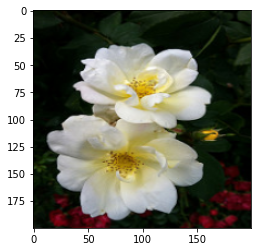

In [6]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

roses = list(data_dir.glob('roses/*'))
filename = str(roses[:10][0])
image = resize(imread(filename), (200,200)) 
print(image.shape)
plt.imshow(image)
plt.show()

In [18]:
# list의 반복
a = [0] * 5
a

[0, 0, 0, 0, 0]

In [12]:
filenames = list(data_dir.glob('roses/*'))
filenames = [ str(x) for x in filenames]
len(filenames) # 641
labels = [0]*len(filenames)
len(labels) # 641
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


(10, 200, 200, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

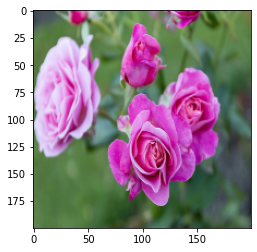

In [20]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(keras.utils.Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    # 미니 배치의 회전수
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
    
    # 1번 미니 배치 돌때 파일의 리스트 목록 리턴
    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size=10)
x,y = sequence.__getitem__(0) # 10개씩 배치로 넘어옴
print(x.shape) # (10, 200, 200, 3)
plt.imshow(x[9])
plt.show
# model.fit(sequence, epochs=10)

## 샘플 가중치 및 클래스 가중치 사용

기본 설정을 사용하면 샘플의 무게가 데이터 세트의 빈도에 따라 결정됩니다. 샘플 빈도와 관계없이 데이터에 가중치를 부여하는 방법에는 두 가지가 있습니다.

- 클래스 가중치
- 샘플 가중치

### 클래스 가중치

이 가중치는 `Model.fit()`에 대한 `class_weight` 인수로 사전을 전달하여 설정합니다. 이 사전은 클래스 인덱스를 이 클래스에 속한 샘플에 사용해야 하는 가중치에 매핑합니다.

이 방법은 샘플링을 다시 수행하지 않고 클래스의 균형을 맞추거나 특정 클래스에 더 중요한 모델을 훈련시키는 데 사용할 수 있습니다.

예를 들어, 데이터에서 클래스 "0"이 클래스 "1"로 표시된 것의 절반인 경우 `Model.fit(..., class_weight={0: 1., 1: 0.5})`을 사용할 수 있습니다.

다음은 클래스 #5(MNIST 데이터세트에서 숫자 "5")의 올바른 분류에 더 많은 중요성을 두도록 클래스 가중치 또는 샘플 가중치를 사용하는 NumPy 예입니다.

In [27]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 2s 2ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.9014


### 샘플 무게

세밀한 제어를 위해 또는 분류기를 작성하지 않는 경우 "샘플 가중치"를 사용할 수 있습니다.

- NumPy 데이터에서 학습하는 경우 : `sample_weight` 인수를 `Model.fit()` .
- `tf.data` 또는 다른 종류의 반복자에서 훈련 할 때 : Yield `(input_batch, label_batch, sample_weight_batch)` 튜플.

"샘플 가중치"배열은 배치에서 각 샘플이 총 손실을 계산하는 데 필요한 가중치를 지정하는 숫자 배열입니다. 불균형 분류 문제 (거의 보이지 않는 클래스에 더 많은 가중치를 부여하는 아이디어)에 일반적으로 사용됩니다.

사용 된 가중치가 1과 0 인 경우, 어레이는 손실 함수에 대한 *마스크* 로 사용될 수 있습니다 (전체 손실에 대한 특정 샘플의 기여를 완전히 버림).

In [36]:
# Boolean index
a = np.ones(shape=(10,))
# a[np.arange(len(a))] = 2 # 전체 인덱스
a[np.arange(len(a))%2==0] = 2 # 짝수 인덱스
a 

array([2., 1., 2., 1., 2., 1., 2., 1., 2., 1.])

In [29]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight
(y_train==5).shape

(50000,)

In [30]:
sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[y_train == 5] = 2.0
sample_weight[(y_train == 5).reshape(50000)] = 2.0 # Boolean index

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 2s 2ms/step - loss: 0.3775 - sparse_categorical_accuracy: 0.8997


일치하는 `Dataset` 예는 다음과 같습니다.

In [37]:
sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[y_train == 5] = 2.0
sample_weight[(y_train == 5).reshape(50000)] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.3603 - sparse_categorical_accuracy: 0.9056


## 다중 입력, 다중 출력 모델로 데이터 전달

이전 예에서는 단일 입력(형상 `(764,)`의 텐서)과 단일 출력(형상 `(10,)`의 예측 텐서)이 있는 모델을 고려했습니다. 그렇다면 입력 또는 출력이 여러 개인 모델은 어떨까요?

shape `(32, 32, 3)` ( `(height, width, channels)` 입력(그림)과 shape `(None, 10)` 의 시계열 입력(텍스트) `(timesteps, features)` 하십시오. 우리의 모델은이 입력들의 조합으로부터 계산 된 두 개의 출력을 가질 것입니다 : "점수"(모양 `(1,)` )와 5 개의 클래스 (모양 `(5,)` )에 대한 확률 분포.

In [46]:
# batch_size=1
image_input = tf.constant(np.arange(32*32*3).reshape(1, 32, 32, 3), dtype=tf.float32)
image_input.shape
x1 = layers.Conv2D(3, 3)(image_input)
x1.shape # TensorShape([1, 30, 30, 3])
x1 = layers.GlobalMaxPooling2D()(x1)
x1.shape # TensorShape([1, 3])

TensorShape([1, 3])

In [52]:
# batch_size=1
timeseries_input = tf.constant(np.arange(1*6*10).reshape(1, 6, 10), dtype=tf.float32)
timeseries_input.shape
x2 = layers.Conv1D(3, 3)(timeseries_input) # (1,6,10)(3,10,3)
x2.shape # (1, 6-3+1=4, filter수=3)
x2 = layers.GlobalMaxPooling1D()(x2)
x2.shape # (1, 3)

TensorShape([1, 3])

In [53]:
x = layers.concatenate([x1, x2]) # (1, 3)+(1, 3) = (1, 6)
x.shape

TensorShape([1, 6])

In [54]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input) # (None, 32, 32, 3)(3, 3, 3, 3)
x1 = layers.GlobalMaxPooling2D()(x1)  # (None, (32-3)+1=30, 30, 3)
                                      # (None, 3)

# NLP Conv1D - 1차원 배열 (width 없고, 열만 존재)
x2 = layers.Conv1D(3, 3)(timeseries_input) # (None, None, 10)(3, 10, 3)
x2 = layers.GlobalMaxPooling1D()(x2)       # (None, 10-3+1=8, 3)

x = layers.concatenate([x1, x2])     # (None, 6)

score_output = layers.Dense(1, name="score_output")(x) # 선형회귀: (None, 6)(6, 1) = (None, 1)
class_output = layers.Dense(5, name="class_output")(x) # 다중분류: (None, 6)(6, 5) = (None, 5)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

이 모델을 플로팅하여 여기서 수행중인 작업을 명확하게 확인할 수 있습니다 (플롯에 표시된 셰이프는 샘플 별 셰이프가 아니라 배치 셰이프 임).

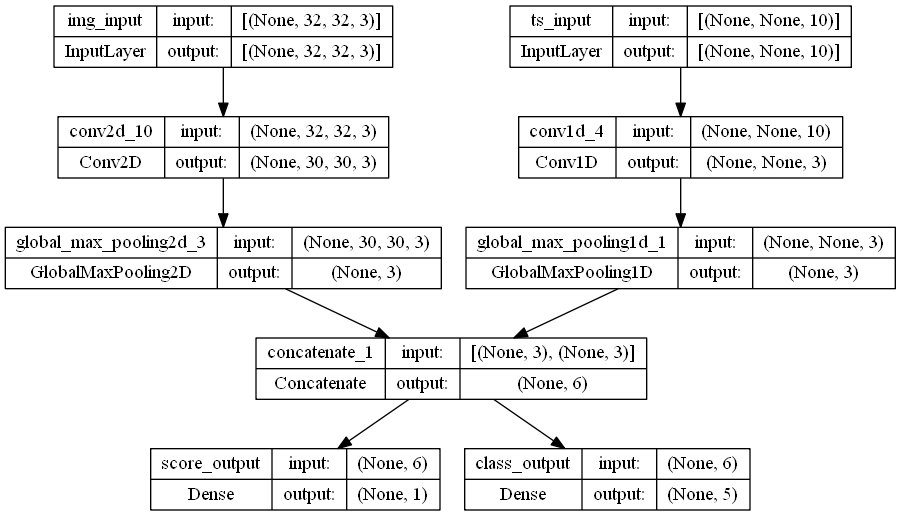

In [55]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

컴파일 타임에 손실 함수를 목록으로 전달하여 출력마다 다른 손실을 지정할 수 있습니다.

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

모델에 단일 손실 함수만 전달하는 경우, 모든 출력에 동일한 손실 함수가 적용됩니다(여기서는 적합하지 않음).

메트릭의 경우도 마찬가지입니다.

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

출력 레이어에 이름을 지정 했으므로 dict를 통해 출력 당 손실 및 메트릭을 지정할 수도 있습니다.

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

출력이 두 개 이상인 경우 명시적 이름과 사전을 사용하는 것이 좋습니다.

`loss_weights` 인수를 사용하여 출력별 손실에 서로 다른 가중치를 부여할 수 있습니다(예를 들어, 클래스 손실에 2x의 중요도를 부여하여 이 예에서 "score" 손실에 우선권을 줄 수 있음).

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

이러한 출력이 예측 용이지만 훈련 용이 아닌 경우 특정 출력에 대한 손실을 계산하지 않도록 선택할 수도 있습니다.

In [ ]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

적합하게 다중 입력 또는 다중 출력 모델에 데이터를 전달하는 것은 컴파일에서 손실 함수를 지정하는 것과 유사한 방식으로 작동합니다. **NumPy 배열 목록을** 전달할 수 있습니다 (손실 함수를 수신 한 출력에 1 : 1 매핑). **출력 이름을 NumPy 배열에 매핑합니다** .

In [56]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 5ms/step - loss: 15.3670 - score_output_loss: 3.3269 - class_output_loss: 12.0401


`Dataset` 사용 사례는 다음과 같습니다. NumPy 배열에서 수행 한 것과 유사하게 `Dataset` 은 튜플 튜플을 반환해야합니다.

In [ ]:
# train_dataset에 입력, batch_size=64
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

## 콜백 사용하기

Keras의 콜백은 훈련 중 다른 시점(epoch의 시작, 배치의 끝, epoch의 끝 등)에서 호출되며 다음과 같은 동작을 구현하는 데 사용할 수 있는 객체입니다.

- 훈련 중 서로 다른 시점에서 유효성 검사 수행(내장된 epoch당 유효성 검사에서 더욱 확장)
- 정기적으로 또는 특정 정확도 임계값을 초과할 때 모델 검사점 설정
- 훈련이 정체 된 것처럼 보일 때 모델의 학습 속도 변경
- 훈련이 정체 된 것처럼 보일 때 최상위 레이어의 미세 조정
- 교육이 종료되거나 특정 성능 임계 값을 초과 한 경우 전자 메일 또는 인스턴트 메시지 알림 보내기
- 기타

콜백은 `fit()` 에 대한 호출에 목록으로 전달 될 수 있습니다.

In [57]:
# Early Stopping
# min_delta, patience 조절하여 val_loss 줄임
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        # 손실(val_loss)이 0.01만큼 나아지지 않는다면
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        # patience = 기회 2번을 주고, 조기 종료
        patience=2,
        verbose=1,
    )
]

# x_train=50000이면, 50000개(781개)를 epochs=20번 돌림
# mini-batch_size = 50000 / 64 = 781
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,   # callback 설정 안하면, epochs=20까지 학습
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 2s 2ms/step - loss: 0.3732 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.2427 - val_sparse_categorical_accuracy: 0.9261
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.1882 - val_sparse_categorical_accuracy: 0.9428
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1721 - val_sparse_categorical_accuracy: 0.9462
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1411 - val_sparse_categorical_accuracy: 0.9571
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.1481 - val_sparse_categorical_accuracy: 0.9581
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0683 - sparse_categorica

### 많은 내장 콜백을 사용할 수 있습니다

- `ModelCheckpoint` : 주기적으로 모델을 저장합니다.
- `EarlyStopping`: 훈련이 더 이상 유효성 검사 메트릭을 개선하지 못하는 경우 훈련을 중단합니다.
- `TensorBoard` : 시각화 할 수 있습니다 정기적으로 쓰기 모델 로그 [TensorBoard](https://www.tensorflow.org/tensorboard) (섹션 "시각화"에서 자세한 내용).
- `CSVLogger` : 손실 및 메트릭 데이터를 CSV 파일로 스트리밍합니다.
- 기타

전체 목록은 [콜백 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) 를 참조하십시오.

### 자신의 콜백 작성

기본 클래스 `keras.callbacks.Callback` 을 확장하여 사용자 정의 콜백을 작성할 수 있습니다. 콜백은 클래스 속성 `self.model` 통해 연관된 모델에 액세스 할 수 있습니다.

[사용자 정의 콜백을 작성하기 위한 전체 가이드](https://www.tensorflow.org/guide/keras/custom_callback/)를 꼭 읽어보세요. 다음은 훈련 중 배치별 손실 값 목록을 저장하는 간단한 예입니다.

다음은 훈련 중 배치 별 손실 값 목록을 저장하는 간단한 예입니다.

In [ ]:
# Callback 상속한 사용자 정의 콜백
class LossHistory(keras.callbacks.Callback):
    # 훈련 시작 시
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    # 배치 끝날때마다
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## 모델 검사점 설정하기

상대적으로 큰 데이터세트에 대한 모델을 훈련시킬 때는 모델의 검사점을 빈번하게 저장하는 것이 중요합니다.

이를 수행하는 가장 쉬운 방법은 `ModelCheckpoint` 콜백을 사용하는 것입니다.

(예: BERT 훈련 시)

In [59]:
# Model Checkpoint
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}", # epoch마다 저장
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
591/625 [===========================>..] - ETA: 0s - loss: 0.3874 - sparse_categorical_accuracy: 0.8898
Epoch 1: val_loss improved from inf to 0.23575, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1\assets
625/625 [==============================] - 2s 3ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.2357 - val_sparse_categorical_accuracy: 0.9282
Epoch 2/2
619/625 [============================>.] - ETA: 0s - loss: 0.1745 - sparse_categorical_accuracy: 0.9467
Epoch 2: val_loss improved from 0.23575 to 0.18841, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2\assets
625/625 [==============================] - 2s 3ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.1884 - val_sparse_categorical_accuracy: 0.9428


`ModelCheckpoint` 콜백을 사용하여 내결함성을 구현할 수 있습니다. 훈련이 무작위로 중단 된 경우 모델의 마지막 저장된 상태에서 훈련을 다시 시작할 수있는 기능. 기본 예는 다음과 같습니다.

In [60]:
# 멈춘 위치부터 실행
import os

# Prepare a directory to store all the checkpoints.
# loss가 줄어들때마다 저장
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    
    # 기존 모델이 있는 경우, 마지막 상태를 리턴
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks) # default minibatch=32
# 결과
# 50000/32 = 1563

Creating a new model
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3175 - sparse_categorical_accuracy: 0.9072


또한 모델 저장 및 복원을 위해 자체 콜백을 작성하십시오.

직렬화 및 저장에 대한 전체 안내서는 [모델 저장 및 직렬화 안내서를](https://www.tensorflow.org/guide/keras/save_and_serialize/) 참조하십시오.

## 학습 속도 일정 사용하기

딥 러닝 모델을 훈련 할 때 일반적인 패턴은 훈련이 진행됨에 따라 점차적으로 학습을 줄이는 것입니다. 이것을 일반적으로 "학습률 감소"라고합니다.

학습 붕괴 스케줄은 정적 인 (현재 에포크 또는 현재 배치 인덱스의 함수로서 미리 고정됨) 또는 동적 (모델의 현재 행동, 특히 검증 손실에 대응) 일 수있다.

### 옵티마이저로 일정 전달하기

옵티 마이저에서 schedule 객체를 `learning_rate` 인수로 전달하여 정적 학습 속도 감소 스케줄을 쉽게 사용할 수 있습니다.

In [ ]:
# 학습 속도 조절
initial_learning_rate = 0.1

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
) # 0.1*0.96 = 0.096으로 느려짐

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

`ExponentialDecay` , `PiecewiseConstantDecay` , `PolynomialDecay` 및 `InverseTimeDecay` 와 같은 몇 가지 기본 제공 일정을 사용할 수 있습니다.

### 콜백을 사용하여 동적 학습 속도 일정 구현

옵티마이저가 유효성 검사 메트릭에 액세스할 수 없으므로 이러한 일정 객체로는 동적 학습률 일정(예: 유효성 검사 손실이 더 이상 개선되지 않을 때 학습률 감소)을 달성할 수 없습니다.

그러나 콜백은 유효성 검사 메트릭을 포함해 모든 메트릭에 액세스할 수 있습니다! 따라서 옵티마이저에서 현재 학습률을 수정하는 콜백을 사용하여 이 패턴을 달성할 수 있습니다. 실제로 이 부분이`ReduceLROnPlateau` 콜백으로 내장되어 있습니다.

## 훈련 중 손실 및 메트릭 시각화하기

교육 중에 모델을 주시하는 가장 좋은 방법은 로컬에서 실행할 수있는 브라우저 기반 응용 프로그램 인 [TensorBoard](https://www.tensorflow.org/tensorboard) 를 사용하는 것입니다.

- 교육 및 평가를위한 손실 및 지표의 라이브 플롯
- (옵션) 레이어 활성화 히스토그램 시각화
- (옵션) `Embedding` 레이어에서 학습한 포함된 공간의 3D 시각화

pip와 함께 TensorFlow를 설치한 경우, 명령줄에서 TensorBoard를 시작할 수 있습니다.

```
tensorboard --logdir=/full_path_to_your_logs
```

### TensorBoard 콜백 사용하기

TensorBoard를 Keras 모델 및 fit 메서드와 함께 사용하는 가장 쉬운 방법은 `TensorBoard` 콜백입니다.

가장 간단한 경우로, 콜백에서 로그를 작성할 위치만 지정하면 바로 쓸 수 있습니다.

In [ ]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

자세한 내용 [`TensorBoard` 콜백 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/)를 참조하세요.